In [94]:
from hierarchy_transformers import HierarchyTransformer
from datasets import Dataset, load_dataset
import pandas as pd
import os
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

This notebook should be submitted with the CSV, but if you want to generate the 

In [ ]:
model = HierarchyTransformer.from_pretrained('Hierarchy-Transformers/HiT-MiniLM-L12-WordNetNoun')
model.to(device='mps')

In [57]:
evaluation_path = os.getcwd() + '/scripts/evaluation/hit/hit_eval_local/'
evaluation_results = pd.read_csv(evaluation_path + "results.tsv", sep='\t')
evaluation_results

,Unnamed: 0,centri_weight,threshold,precision,recall,f1,accuracy,accuracy_on_negatives
0,validation,2.0,-13.04,0.877274,0.895494,0.886290,0.979111,0.987472
1,testing,2.0,-13.04,0.876915,0.893568,0.885163,0.978922,0.987458


### Let's look at the embeddings in the Train dataset, because those ones should be more representative of the type of result we want

In [ ]:
pairs_dataset = load_dataset("Hierarchy-Transformers/WordNetNoun", "MixedHop-RandomNegatives-Pairs")
pairs_dataset

In [ ]:
# we first want to encode all of the available entities. 
entity_names = list(set(pairs_dataset['train']['child'] + pairs_dataset['train']['parent']))
entity_embeddings = model.encode(entity_names) # 38 seconds

/opt/homebrew/Caskroom/miniconda/base/envs/hierarchytransformers/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/hierarchytransformers/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


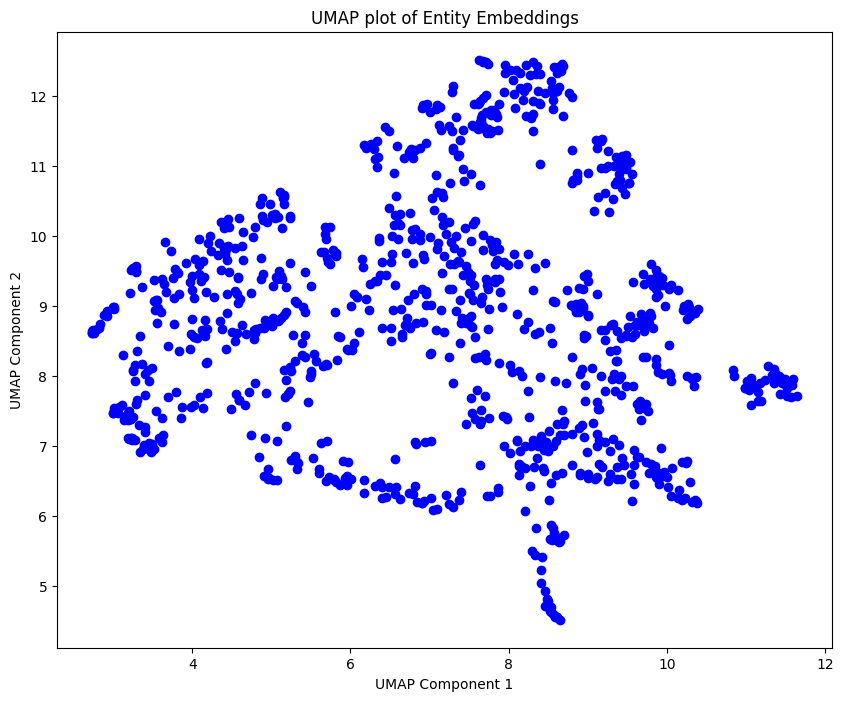

In [ ]:
# acutally Umaping on 60k pairs is hard, here we take a subset of 1k to show embeddings
import umap

embeddings_to_plot = entity_embeddings[np.random.choice(len(entity_embeddings), size=1000, replace=False)]

# Perform UMAP on the entity embeddings
umap_model = umap.UMAP(n_components=2, random_state=42)
entity_embeddings_2d = umap_model.fit_transform(embeddings_to_plot)

# Plot the UMAP results
plt.figure(figsize=(10, 8))
plt.scatter(entity_embeddings_2d[:, 0], entity_embeddings_2d[:, 1], c='blue', marker='o')
plt.title('UMAP plot of Entity Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [ ]:
# Subset the dataset to include only rows where the 'label' column has the value 1
proper_pairs = pairs_dataset['train'].filter(lambda data: data['label'] == 1)
proper_pairs_subset = proper_pairs.shuffle(seed=42).select(range(1000))

In [ ]:
child_entity_embeddings = model.encode(proper_pairs['child'], convert_to_tensor=True)
parent_entity_embeddings = model.encode(proper_pairs['parent'], convert_to_tensor=True)

#OK need to figure out a way to plot these that is interesting. 

In [ ]:
# compute the hyperbolic distances and norms of entity embeddings
dists = model.manifold.dist(child_entity_embeddings, parent_entity_embeddings)
child_norms = model.manifold.dist0(child_entity_embeddings)
parent_norms = model.manifold.dist0(parent_entity_embeddings)

# use the empirical function for subsumption prediction proposed in the paper

centri_score_weight = evaluation_results.iloc[0, 1] # use the result on the validation set per the README
threshold = evaluation_results.iloc[0, 2]


subsumption_scores = - (dists + centri_score_weight * (parent_norms - child_norms))